# Cord-Cutting and Streaming Content

“Cord- Cutting”, the pattern of viewers cancelling their subscriptions to traditional cable companies in favor of multichannel subscription services.<p>
Like-Minded “cord cutters” flock to reddit to share their experiences.<p>
This project intends to figure out what drives people to cut the cord, what they look for in streaming services, their favorite shows and complaints (if any) with the streaming services.

#### Data Source
Using the Reddit API and pushshift.io (Big Query), the data are comments extracted from cordcutter subreddit for the last 4 months. The data is totaled as over 28k comments. <p>
Preprocessing includes Parentheses, commas, asterisks, Short comments (less than 10 words), Various forms of the service names to a common name, and so on. 


In [13]:
from sklearn import manifold
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
#additional package for plot is needed
import sys
!{sys.executable} -m pip install adjustText
from adjustText import adjust_text
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import csv
from matplotlib.pyplot import bar
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import operator
import os

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Data Import and Cleaning

The data is scraped and parsed from Reddit via API, and contains some "deleted" record, which will be eliminated here.

In [3]:
comment_09 = []
with open('/Users/k.vincent/Downloads/2018-09.csv', 'rt') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        comment_09.append(row)
comment_06 = []
with open('/Users/k.vincent/Downloads/2018-06.csv', 'rt') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        comment_06.append(row)
        
comment_07 = []
with open('/Users/k.vincent/Downloads/2018-07.csv', 'rt') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        comment_07.append(row)
        
comment_08 = []
with open('/Users/k.vincent/Downloads/2018-08.csv', 'rt') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        comment_08.append(row)
        
comments = []
comments = comment_06+comment_07+comment_08+comment_09
comments_origin = comments.copy()

#eliminate deletion
for comment in comments:
    if comment[1] == '[deleted]' or comment[1] == '[removed]':
        comments.remove(comment)

## Determine what cable companies, streaming services and channel to research. 
The list is discussed and decided through group discuss, and refined by exluding less popular ones. <br>
Since we have lots of cable companies to consider, I seek to check the occurance of each first. Some cable companies are less popular and may not fully discussed on the forum. This project will exclude those companies as the data cannot suggest insights.
Only companies with 100 or more mentions will be included.

In [11]:
temp = {}

companies = ['XFINITY'
,'Time Warner'
,'Charter'
,'Cox'
,'Optimum'
,'Bright House'
,'WOW'
,'Mediacom'
,'Suddenlink'
,'RCN'
,'Cable One'
,'Summit'
,'Wave Broadband'
,'Service Electric']
for company in companies: 
    for ct in comments:
        if company.lower() in ct[1].lower(): 
            if company in temp.keys():
                temp[company] = temp[company]+1
                continue
            temp[company] = 1

In [12]:
temp

{'XFINITY': 233,
 'Time Warner': 80,
 'Charter': 161,
 'Cox': 123,
 'Optimum': 52,
 'Bright House': 7,
 'WOW': 161,
 'Mediacom': 10,
 'Suddenlink': 9,
 'RCN': 16,
 'Cable One': 3,
 'Summit': 1,
 'Wave Broadband': 1,
 'Service Electric': 1}

## Synonyms Replacement

One company/channel/service may have several names. Hereby I use a list of word count to find them, and replace those words with the same name for accurate identification. <br>Considering Zipf's Law, the synonyms that have significant impact may not be too many and we can screen through the most frequent words to find them. <br>
https://en.wikipedia.org/wiki/Zipf%27s_law

In [15]:
tokenizer = RegexpTokenizer(r'\w+')

stop_words = set(stopwords.words('english'))
stop_words.add("\n")

fdist = Counter()

for ct in comments:
    temp_token = tokenizer.tokenize(ct[1].lower())
    filtered_sentence = [w for w in temp_token if not w in stop_words] 
    fdist.update(filtered_sentence)
    
temp_dict = dict(fdist)
sorted_dict = sorted(temp_dict.items(), key=operator.itemgetter(1), reverse = True)


#word count of the whole corpus, to screen through and find replacement
sorted_dict

os.chdir("/Users/k.vincent/Desktop/")
with open('dict.csv', 'wt') as csv_file:
    writer = csv.writer(csv_file, dialect='excel')
    for i in sorted_dict:
         writer.writerow(i)

#### Import the lists of cable companies, channels and services. <br>
#### Also, replace synonyms of companies with the same name. 

In [34]:
cable_com = []
channel = []
service = []
with open('/Users/k.vincent/Desktop/MSBA Course - Fall 2018/Text Analytics/Final Project/Cable Company.csv'\
          , 'r',encoding="utf8", errors='ignore') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        cable_com.append(row[0].lower())
    #this is to fix import problem in the first row
    cable_com[0] = 'XFINITY'
#add additional target companies after discussion
cable_com.append("fubo")
cable_com.append("spectrum")

with open('/Users/k.vincent/Desktop/MSBA Course - Fall 2018/Text Analytics/Final Project/Channel.csv'\
          , 'r',encoding="utf8", errors='ignore') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        channel.append(row[0].lower())
    #this is to fix import problem in the first row
    channel[0] = 'abc'
    
    

with open('/Users/k.vincent/Desktop/MSBA Course - Fall 2018/Text Analytics/Final Project/Service.csv'\
          , 'r',encoding="utf8", errors='ignore') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        service.append(row[0].lower())
    #this is to fix import problem in the first row
    service[0] = 'youtube'
#drop duplicates
service = list(set(service))

In [35]:
#import the mapping data for cleaning
mapping = {}
with open('/Users/k.vincent/Desktop/MSBA Course - Fall 2018/Text Analytics/Final Project/mapping.csv', 'r',encoding="utf8", errors='ignore') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
            mapping[row[1].lower()] = row[0].lower()
#this is to fix import problem in the first row
mapping["yttv"] = "youtube"

pure_comments = [i[1] for i in comments[1:]]
#all comments to lower
for i in range(0,len(pure_comments)):
    pure_comments[i] = pure_comments[i].lower()
    
#replace model with brand
for i in range(0,len(pure_comments)):
    for key in mapping.keys():
        if key in pure_comments[i]:
            pure_comments[i] = pure_comments[i].replace(key, mapping[key])

#"pure_comments" is the corpus we will use for MDS

#### Filtering out some less frequent mentioned targets.<br>
Though we have filtered the cable companies, some streaming services and channels also have few mentions. Let's drop it here.

In [36]:
#count the total occurance of those service, channel and cable company
total = service +channel + cable_com

provider_count = {}
for node in pure_comments: 
    for provider in total: 
        if provider in node:
            if provider in provider_count.keys():
                provider_count[provider] = provider_count[provider]+1
                continue
            provider_count[provider] = 1

provider_count['spectrum'] = provider_count['spectrum'] +provider_count['time warner'] 
del provider_count['time warner']
#too many keywords have few mentions. Consider only those mentioned more than 100 times for MDS
provider_count100 = {}
for key, value in provider_count.items():
    if value< 100:
        continue
    provider_count100[key] = value

#provider_count100 is the all the service, channel and cable company we'll use for MDS

Some corporations were hard to categorize or belong to several categories. After discussion, we fix the category here. 

In [37]:
##corporation type changes:
try:
    service.remove("comcast")
    cable_com.append("comcast")
except:
    pass
try:
    service.remove("directv")
    cable_com.append("directv")
except:
    pass

try:
    cable_com.remove("fubo")
    service.append("fubo")
except:
    pass

try:
    service.remove("pbs")
    channel.append("pbs")
except:
    pass

try:
    service.remove("hbo")
    channel.append("hbo")
except:
    pass

## Lift among the companies, and the Multidimensional Scaling (MDS)<br>
With the target lists, we now use their lift to each other to see how people are associating them in the forum. <br> The lift, because it's pair-wise, will be in a high dimensional space. To visualize, here we apply multidimenional scaling to do dimensionality reduction. 

In [29]:
class lift:
    N = 0
    corpus = None
    #input an array-like corpus to init
    def __init__(self, corpus):
        self.N = len(corpus)
        self.corpus = corpus
    
    def __count__(self, keyword1, keyword2 = None):
        if self.corpus == None:
            print("unspecified corpus")
            return
        count = 0
        if keyword2 == None:
            for node in self.corpus: 
                if keyword1 in node:
                    count = count +1 
            return count
        for node in self.corpus: 
            if keyword1 in node and keyword2 in node:
                count = count+1
        return count
    
    #return a lift of the two keywords
    def getLift(self,keyword1, keyword2):
        both = self.__count__(keyword1, keyword2)
        k1 = self.__count__(keyword1)
        k2 = self.__count__(keyword2)
        
        try:
            return ((self.N*both)/(k1*k2))
        except ZeroDivisionError:
            if k1 ==0:
                k1 = k1+1
            if k2 == 0:
                k2 = k2+1
            return ((self.N*both)/(k1*k2))

Calculate the lift and dissimilarity matrix.

In [30]:
myLift = lift(pure_comments)

providers_ = list(provider_count100.keys())

#calculate the similarities(lift) matrix of each brand for the plotting later. 
dissimilarities = []
for prov in providers_: 
    k1brand = prov
    local = []
    for prov in providers_:
        k2brand = prov
        if k1brand == k2brand:
            local.append(0.0000001)
            continue
        try: 
            local.append((1/myLift.getLift(k1brand,k2brand))+0.0000001)
        except ZeroDivisionError: 
            #for the case of lift = 0
            #approximate by adding a really small number
            local.append((1/(myLift.getLift(k1brand,k2brand)+0.00000000001))+0.0000001)
    dissimilarities.append(local)

Plot the dissimilarity matrix

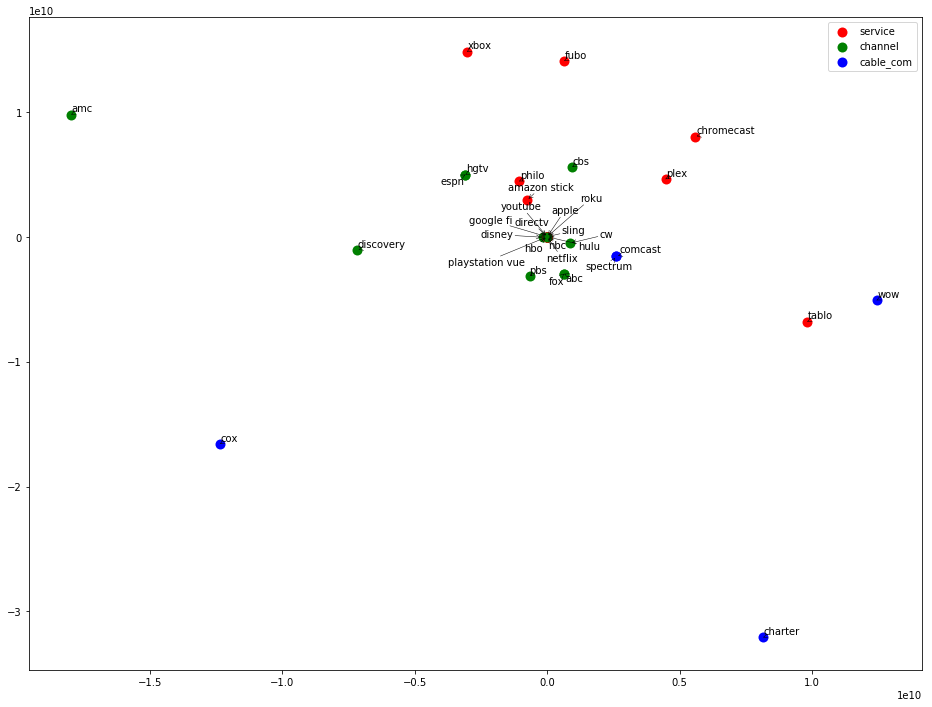

In [31]:
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=99,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(dissimilarities).embedding_

#plot
figure(figsize=(16,12))

#the tick thing is just a shortcut for tackling legend. Just leave it.
tick_s = 0
tick_cc = 0
tick_ch = 0
for i in range(0,pos.shape[0]):
    if providers_[i] in service:
        co ="r"
        lab = "service"
        if tick_s >0:
            lab = None
        tick_s = tick_s+1
    elif providers_[i] in cable_com:
        co ="b"
        lab = "cable_com"
        if tick_cc >0:
            lab = None
        tick_cc = tick_cc+1
    elif providers_[i] in channel:
        co ="g"
        lab = "channel"
        if tick_ch >0:
            lab = None
        tick_ch = tick_ch+1
    else:
        print("Not Specified type of element")
        break
    plt.scatter(pos[i, 0], pos[i, 1], color=co, s=100, lw=0, label=lab)
plt.legend()


#add labels for each brand
texts = []
for x, y, s in zip(pos[:, 0], pos[:, 1], providers_):
    texts.append(plt.text(x, y, s))
adjust_text(texts,arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
plt.show

plt.savefig('all_in_one.png',bbox_inches = 'tight', dpi = 600)

The plot above shows that most of cable companies are extremely not associated with others. People don't really discuss them against channel and services.

MDS may be inaccurate when processing too many dots. Also, too many dots make several companies are overlapped with each other. For readability, we compare the services against channels to see how people assiciate content with streaming services first. 
Take the log value to smooth the effect of high dissmiliarities on readability.

<function matplotlib.pyplot.show(*args, **kw)>

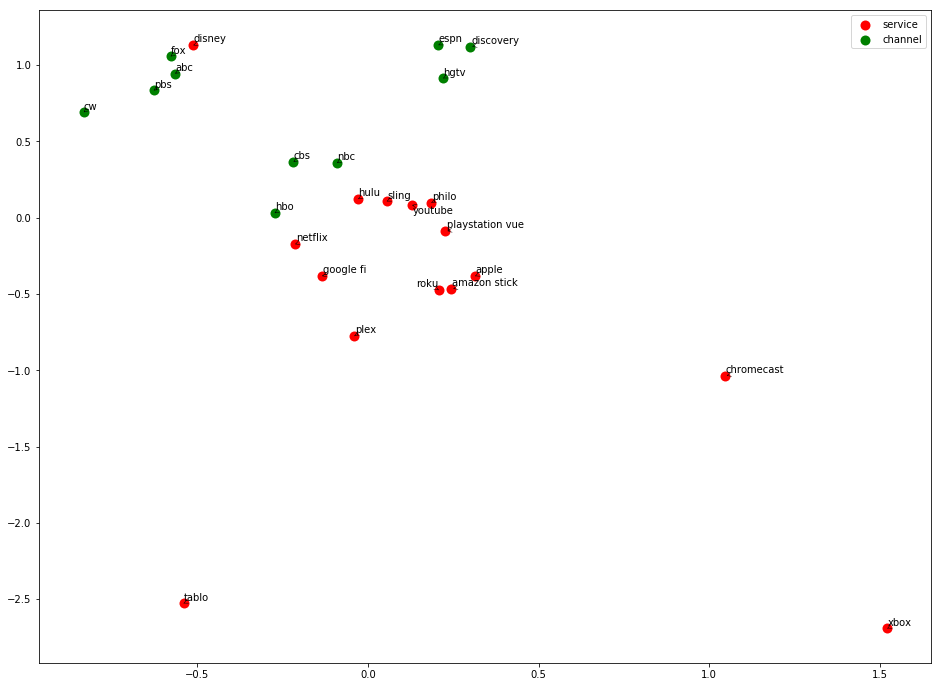

In [47]:
providers_center = providers_.copy()

to_remove = ["fire stick",'wow','cox','charter','amc','fubo','spectrum','directv','comcast']
for element in to_remove:
    try:
        providers_center.remove(element)
    except:
        continue


#calculate the similarities(lift) matrix of each brand
dissimilarities = []
for prov in providers_center: 
    k1brand = prov
    local = []
    for prov in providers_center:
        k2brand = prov
        if k1brand == k2brand:
            local.append(log(1+0.0000001,2))
            continue
        try: 
            local.append(log(1+(1/myLift.getLift(k1brand,k2brand))+0.0000001,2))
        except ZeroDivisionError: 
            #lift = 0
            #approximate by adding a really small number
            local.append(log(1+(1/(myLift.getLift(k1brand,k2brand)+0.00001))+0.0000001,2))
    dissimilarities.append(local)
    
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=99,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(dissimilarities).embedding_

#plot
figure(figsize=(16,12))

#Disney is developping streaming service as well. It actually belongs to both categories. 
try:
    channel.remove("disney")
    service.append("disney")
except:
    pass

#the tick thing is just a shortcut for tackling legend. Just leave it.
tick_s = 0
tick_cc = 0
tick_ch = 0
for i in range(0,pos.shape[0]):
    if providers_center[i] in service:
        co ="r"
        lab = "service"
        if tick_s >0:
            lab = None
        tick_s = tick_s+1
    elif providers_center[i] in cable_com:
        co ="b"
        lab = "cable_com"
        if tick_cc >0:
            lab = None
        tick_cc = tick_cc+1
    elif providers_center[i] in channel:
        co ="g"
        lab = "channel"
        if tick_ch >0:
            lab = None
        tick_ch = tick_ch+1
    else:
        print("Not Specified type of element")
        break
    plt.scatter(pos[i, 0], pos[i, 1], color=co, s=100, lw=0, label=lab)
plt.legend()


#add labels for each brand
texts = []
for x, y, s in zip(pos[:, 0], pos[:, 1], providers_center):
    texts.append(plt.text(x, y, s))
adjust_text(texts,arrowprops=dict(arrowstyle="->", color='black', lw=0.5))

plt.savefig('Channel_service.png',bbox_inches = 'tight', dpi = 600)
plt.show

After removing the cable companies, we can see which channels are associated with which services. The plot shows a clear pattern distinguishing services and channel.<p> Within the cluster of channel, we can observe 3 sub-cluster: the "Disney Cluster", the "ESPN-Discovery Cluster" and the cluster highly assicoated to streaming services. <br>
    
Disney is interestingly associated with Fox and ABC, and this is probably due to Disney’s acquisition of FOX and the upcoming streaming service. Disney successfully forms a unique stand that differentiate their content from other channels. <p>
The ESPN-Discovery cluster is the most surprising one. HGTV, also in the cluster, is owned by Discovery and no wonder in the cluster. However, ESPN and Discovery provide very different content and appear in the same cluster. This indicates that people often these two channels together in the same comment. <p>
Lastly, CBS, NBC and HBO is highly assocaited with streaming services. This may suggest that their content is highly compatible with streamings. HBO is not a surprise to be in-between netflix and hulu as their content is quite similar. 

Last but not least, to see how the cable companies associated with streaming services, as they are facing severe competition against streamings. 

<function matplotlib.pyplot.show(*args, **kw)>

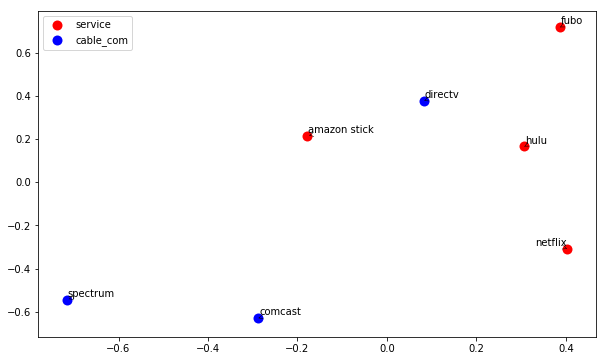

In [48]:
myLift = lift(pure_comments)
providers_center= ['netflix', 'hulu', 'fubo', 'comcast', 'directv', 'spectrum','amazon stick']
#calculate the similarities(lift) matrix of each brand
dissimilarities = []
for prov in providers_center: 
    k1brand = prov
    local = []
    for prov in providers_center:
        k2brand = prov
        if k1brand == k2brand:
            local.append(log(1+0.0000001,2))
            continue
        try: 
            local.append(log(1+(1/myLift.getLift(k1brand,k2brand))+0.0000001,2))
        except ZeroDivisionError: 
            #lift = 0
            #approximate by adding a really small number
            local.append(log(1+(1/(myLift.getLift(k1brand,k2brand)+0.00001))+0.0000001,2))
    dissimilarities.append(local)
    
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=99,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(dissimilarities).embedding_

#plot
figure(figsize=(10,6))
#the tick thing is just a shortcut for tackling legend. Just leave it.
tick_s = 0
tick_cc = 0
tick_ch = 0
for i in range(0,pos.shape[0]):
    if providers_center[i] in service:
        co ="r"
        lab = "service"
        if tick_s >0:
            lab = None
        tick_s = tick_s+1
    elif providers_center[i] in cable_com:
        co ="b"
        lab = "cable_com"
        if tick_cc >0:
            lab = None
        tick_cc = tick_cc+1
    elif providers_center[i] in channel:
        co ="g"
        lab = "channel"
        if tick_ch >0:
            lab = None
        tick_ch = tick_ch+1
    else:
        print("Not Specified type of element")
        break
    plt.scatter(pos[i, 0], pos[i, 1], color=co, s=100, lw=0, label=lab)
plt.legend()


#add labels for each brand
texts = []
for x, y, s in zip(pos[:, 0], pos[:, 1], providers_center):
    texts.append(plt.text(x, y, s))
adjust_text(texts,arrowprops=dict(arrowstyle="->", color='black', lw=0.5))


plt.savefig('specified topics',bbox_inches = 'tight', dpi = 600)
plt.show 

This plot shows us how cable TV are related to streamings, and how potentially people may cut the cord and turn to streamings. The position of directv is interesting: this may positively indicate that people think of them more with streaming, but also negatively suggest that some users are cutting the cord and considering some of the "surrounding streaming services."

## LDA topics modeling

In [49]:
#remove stopwords 
#since our method does not include tokenize, I add blank at the beginning and end of a stop word.
#Otherwise we'll be removing "character" not "word" 
stop_words = list(stopwords.words('english'))
for i in range(0,len(stop_words)): 
    stop_words[i] = " "+stop_words[i] + " "

#remove
for i in range(0,len(pure_comments)): 
    for stop in stop_words:
        if stop in pure_comments[i]:
            pure_comments[i]=pure_comments[i].replace(stop,' ')
        if '\n' in pure_comments[i]:
            pure_comments[i]=pure_comments[i].replace('\n','')

documents = pure_comments

In [50]:
#data pre-processing for LDA topics modeling: we need tf of the corpus

no_features = 100
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [51]:
# Run LDA
lda = LatentDirichletAllocation(n_topics=5, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("..Topic %d:" % (topic_idx))
        top10_fraction = []
        for i in topic.argsort()[:-no_top_words - 1:-1]:
            print (".."+" ".join([feature_names[i]])+", Fraction = %f\n"%(topic[i]/sum(topic)))
            top10_fraction.append((topic[i]/sum(topic)))
        print("..top10_fraction = %f\n"%sum(top10_fraction))
no_top_words = 5
display_topics(lda, tf_feature_names, no_top_words)

/Users/k.vincent/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


..Topic 0:
..tv, Fraction = 0.107545

..channels, Fraction = 0.070780

..vuevue, Fraction = 0.060599

..playstation, Fraction = 0.043855

..streaming, Fraction = 0.041113

..top10_fraction = 0.323891

..Topic 1:
..google, Fraction = 0.234248

..amazon, Fraction = 0.161706

..good, Fraction = 0.059005

..know, Fraction = 0.039993

..new, Fraction = 0.038247

..top10_fraction = 0.533199

..Topic 2:
..vuevue, Fraction = 0.107312

..hulu, Fraction = 0.066169

..watch, Fraction = 0.065321

..netflix, Fraction = 0.064378

..com, Fraction = 0.057394

..top10_fraction = 0.360575

..Topic 3:
..antenna, Fraction = 0.093325

..cable, Fraction = 0.083395

..month, Fraction = 0.068879

..internet, Fraction = 0.064764

..channel, Fraction = 0.047362

..top10_fraction = 0.357726

..Topic 4:
..like, Fraction = 0.168524

..time, Fraction = 0.133101

..ve, Fraction = 0.114827

..people, Fraction = 0.114316

..really, Fraction = 0.113505

..top10_fraction = 0.644273



## Topics Association with Companies<br>
After considering two version of topics modeling (refer to "LDA with Pre-TOken Set"), I found that the "LDA with Pre-TOken Set" is more interpretable and has more potential findings. Thus I then included the "lift" between each cable company/channel/services and each topics. <br>
Some representative words of each topic were picked and replaced to the corpus, then the lift was calculated. 

Reload the dataset

In [80]:
cable_com = []
channel = []
service = []
with open('/Users/k.vincent/Desktop/MSBA Course - Fall 2018/Text Analytics/Final Project/Cable Company.csv'\
          , 'r',encoding="utf8", errors='ignore') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        cable_com.append(row[0].lower())
    cable_com[0] = 'XFINITY'
cable_com.append("fubo")
cable_com.append("spectrum")

with open('/Users/k.vincent/Desktop/MSBA Course - Fall 2018/Text Analytics/Final Project/Channel.csv'\
          , 'r',encoding="utf8", errors='ignore') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        channel.append(row[0].lower())
    channel[0] = 'abc'
    
    

with open('/Users/k.vincent/Desktop/MSBA Course - Fall 2018/Text Analytics/Final Project/Service.csv'\
          , 'r',encoding="utf8", errors='ignore') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        service.append(row[0].lower())
    service[0] = 'youtube'
#drop duplicates
service = list(set(service))


#import the mapping data for cleaning
mapping = {}
with open('/Users/k.vincent/Desktop/MSBA Course - Fall 2018/Text Analytics/Final Project/mapping.csv', 'r',encoding="utf8", errors='ignore') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
            mapping[row[1].lower()] = row[0].lower()
mapping["yttv"] = "youtube"

pure_comments = [i[1] for i in comments[1:]]
#all comments to lower
for i in range(0,len(pure_comments)):
    pure_comments[i] = pure_comments[i].lower()
    
#replace model with brand
for i in range(0,len(pure_comments)):
    for key in mapping.keys():
        if key in pure_comments[i]:
            pure_comments[i] = pure_comments[i].replace(key, mapping[key])

#"pure_comments" is the corpus we will use for MDS
#count the total occurance of those service, channel and cable company
total = service +channel + cable_com


try:
    service.remove("comcast")
    cable_com.append("comcast")
except:
    pass
try:
    service.remove("directv")
    cable_com.append("directv")
except:
    pass

try:
    cable_com.remove("fubo")
    service.append("fubo")
except:
    pass

try:
    service.remove("pbs")
    channel.append("pbs")
except:
    pass

try:
    service.remove("hbo")
    channel.append("hbo")
except:
    pass


#provider_count100 is the all the service, channel and cable company we'll use for MDS

The topics generated from "LDA_with_preToken_set.ipynb" are User experience, Net Neutrality, Sport Package, Traditional Cable Experience.
<p>Topics and keywords include: <br>
User Experience - Update, Interface, Guide, Provider, Support, Disconnect<br>
Net Neutrality - Neutrality, Throttling, Jefferson (Thomas Jefferson), Speed, Internet<br>
Sports Packages - Soccer, Football, Sport, Monthly, Watch<br>
Traditional Cable Experience - Antenna, Comcast, Tuner, Broadband<br>
    
"Comcast" appears in the traditional cable topics, suggesting it as a representative cable company. We now are goint to pick up some keyword and see the lift between topics and companies. 

In [81]:
#topics
UX = ['Update', 'Interface', 'Guide', 'Provider', 'Support', 'Disconnect']
UX = [i.lower() for i in UX]
NN = ['Neutrality', 'Throttling', 'Speed', 'Internet']
NN = [i.lower() for i in NN]
Sport = ['Soccer', 'Football', 'Sport', 'Watch']
Sport = [i.lower() for i in Sport]
Trad_cable_exp = ['Antenna', 'Tuner', 'Broadband']
Trad_cable_exp = [i.lower() for i in Trad_cable_exp]


In [82]:
mapping = {}
mapping["UX"] = UX
mapping["NN"] = NN
mapping["Sport"] = Sport
mapping["TCexp"] = Trad_cable_exp
#---
comment_dict = {}
#replace model with brand
for i in range(0,len(pure_comments)):
    for key, value in mapping.items():
        y = 0
        for word in value:
            if word in pure_comments[i]:
                y = 1
                pure_comments[i] = pure_comments[i].replace(word, str(key).lower())
        if y ==1:
            try: 
                comment_dict[str(key)].append([pure_comments[i]])
            except: 
                comment_dict[str(key)] = []
                comment_dict[str(key)].append([pure_comments[i]])
            
#"pure_comments" is the corpus we will use for MDS

In [83]:
os.chdir("/Users/k.vincent/Desktop/")
with open('ux.csv', 'w') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    for i in comment_dict['UX']:
         writer.writerow(i)

os.chdir("/Users/k.vincent/Desktop/")
with open('Trad_cable_exp.csv', 'w') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    for i in comment_dict['TCexp']:
         writer.writerow(i)
            
os.chdir("/Users/k.vincent/Desktop/")
with open('NN.csv', 'w') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    for i in comment_dict['NN']:
         writer.writerow(i)
            
os.chdir("/Users/k.vincent/Desktop/")
with open('Sport.csv', 'w') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    for i in comment_dict['Sport']:
         writer.writerow(i)

In [84]:
myLift = lift(pure_comments)
topics = list(mapping.keys())
providers_for_topics= ['netflix', 'hulu', 'fubo', 'comcast', 'directv', 'spectrum', \
                       'amazon stick', 'cox']

topic_prov_lift = {}
for _providers_ in providers_for_topics:
    for topic in topics:
        topic_prov_lift[topic.lower()+" - "+_providers_] = myLift.getLift(_providers_, topic.lower())


Sentiment Score of each topics is estimated by teammate using bi-gram PMI.

In [86]:
#sentiment
import numpy as np
nn_senti = []
with open('/Users/k.vincent/Downloads/nn_with_sentiments.csv'\
          , 'r',encoding="utf8", errors='ignore') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    t = 0
    for row in spamreader:
        if t == 0:
            t = 1
            continue
        nn_senti.append(float(row[2]))
nn_sentiment_score = np.mean(nn_senti)

spt_senti = []
with open('/Users/k.vincent/Downloads/sport_with_sentiments.csv'\
          , 'r',encoding="utf8", errors='ignore') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    t = 0
    for row in spamreader:
        if t == 0:
            t = 1
            continue
        spt_senti.append(float(row[2]))
sport_sentiment_score = np.mean(spt_senti)


tcexp_senti = []
with open('/Users/k.vincent/Downloads/Trad_cable_exp_with_sentiments.csv'\
          , 'r',encoding="utf8", errors='ignore') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    t = 0
    for row in spamreader:
        if t == 0:
            t = 1
            continue
        tcexp_senti.append(float(row[2]))
tc_exp_sentiment_score = np.mean(tcexp_senti)

ux_senti = []
with open('/Users/k.vincent/Downloads/ux_with_sentiments.csv'\
          , 'r',encoding="utf8", errors='ignore') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    t = 0
    for row in spamreader:
        if t == 0:
            t = 1
            continue
        ux_senti.append(float(row[2]))
ux_sentiment_score = np.mean(ux_senti)

#### Print out the lift of targeted companies and topics.

From the plot, we can find: 
    <p>
1. Fubo and directv are more concerned with user experience. <br>
2. Spectrum and Cox are related to net neutrality. <br>
3. Fubo of course is discussed as sport content. <br>
4. Amazon Stick appears to be highly associated with traditional cable company. When people talking about cable TV, they also consider Amazon Stick, maybe as an alternative. 

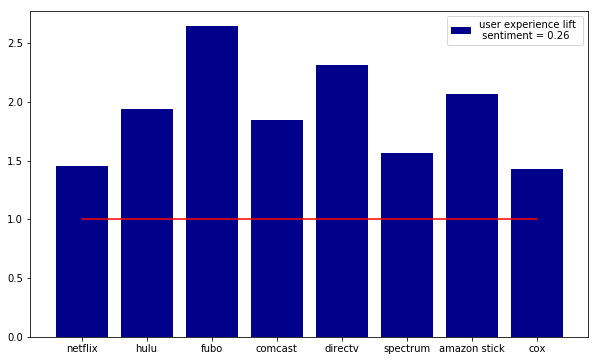

In [88]:
label = []
val = []
for key, value in topic_prov_lift.items(): 
    if (str(key))[0:2] == 'ux':
        label.append(str(key)[5:])
        val.append(value)
figure(figsize=(10,6))
bar(label, val, color = "darkblue")
plt.legend(['user experience lift \n sentiment = %.2f'%ux_sentiment_score])
plt.plot(range(0,8),[1]*8, color = "red")
plt.savefig('ux',bbox_inches = 'tight', dpi = 400)
plt.show()

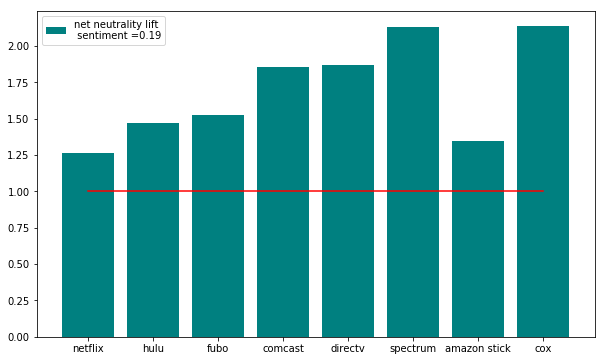

In [89]:
label = []
val = []
for key, value in topic_prov_lift.items(): 
    if (str(key))[0:2] == 'nn':
        label.append(str(key)[5:])
        val.append(value)
figure(figsize=(10,6))
bar(label, val, color = "teal")
plt.legend(['net neutrality lift \n sentiment =%.2f'%nn_sentiment_score])
plt.plot(range(0,8),[1]*8, color = "red")
plt.savefig('nn',bbox_inches = 'tight', dpi = 400)
plt.show()

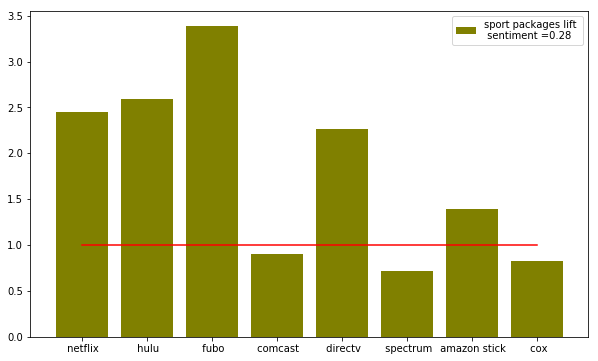

In [90]:
label = []
val = []
for key, value in topic_prov_lift.items(): 
    if (str(key))[0:2] == 'sp':
        label.append(str(key)[7:])
        val.append(value)
figure(figsize=(10,6))
bar(label, val, color = "olive")
plt.legend(['sport packages lift \n sentiment =%.2f'%sport_sentiment_score])
plt.plot(range(0,8),[1]*8, color = "red")
plt.savefig('sport',bbox_inches = 'tight', dpi = 400)
plt.show()

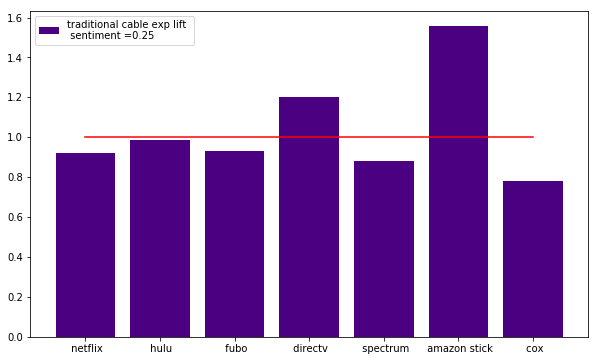

In [91]:
label = []
val = []
for key, value in topic_prov_lift.items(): 
    if (str(key))[0:2] == 'tc' and str(key)[7:] != " comcast":
        label.append(str(key)[7:])
        val.append(value)
figure(figsize=(10,6))
bar(label, val, color = "indigo")
plt.legend(['traditional cable exp lift \n sentiment =%.2f'%tc_exp_sentiment_score])
plt.plot(range(0,7),[1]*7, color = "red")
plt.savefig('traditional cable',bbox_inches = 'tight', dpi = 400)
plt.show()

#### What are the tendencies of people who cut the cord?
This project mined relevant entities from the comments.<br>
MDS Plotting shows divides between channels, services, and cable companies.<p>

<br>



#### What are the concerns of cord-cutters?
LDA shows important topics are sports packages, net neutrality, the traditional cable experience, and user experience<br>
Niche products – FuboTV – are associated more with "product related topics (sport, UX)" as opposed to "general interest topics".
